# Améliorations du pricing d'options asiatiques

Ce notebook regroupe des fonctions de pricing asiatiques améliorées (Monte Carlo avec variates antithétiques et control variate géométrique) ainsi que quelques expériences numériques.

Il est indépendant de `streamlit_app.py` : tu peux tester ici, puis éventuellement réintégrer des idées dans l'application Streamlit.

In [28]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("seaborn-v0_8")

## 1. Formule fermée géométrique (rappel)

On commence par la formule fermée pour l'option asiatique géométrique (call/put), qui nous servira de variable de contrôle dans le Monte Carlo arithmétique.

In [29]:
def asian_geometric_closed_form(spot, strike, rate, sigma, maturity, n_obs, option_type):
    """Prix fermé d'une option asiatique géométrique continue (approx discrète) sous GBM.

    Paramètres
    ----------
    spot : float
        S0.
    strike : float
        K.
    rate : float
        Taux sans risque r.
    sigma : float
        Volatilité.
    maturity : float
        Maturité T (années).
    n_obs : int
        Nombre d'observations de la moyenne.
    option_type : {"call", "put"}
        Type d'option.
    """
    if n_obs < 1:
        return 0.0
    dt = maturity / n_obs
    nu = rate - 0.5 * sigma ** 2
    sigma_g_sq = (sigma ** 2) * (n_obs + 1) * (2 * n_obs + 1) / (6 * n_obs ** 2)
    sigma_g = np.sqrt(sigma_g_sq)
    mu_g = (nu * (n_obs + 1) / (2 * n_obs) + 0.5 * sigma_g_sq) * maturity
    d1 = (np.log(spot / strike) + mu_g + 0.5 * sigma_g_sq * maturity) / (sigma_g * np.sqrt(maturity))
    d2 = d1 - sigma_g * np.sqrt(maturity)
    df = np.exp(-rate * maturity)
    if option_type == "call":
        return float(df * (spot * np.exp(mu_g) * norm.cdf(d1) - strike * norm.cdf(d2)))
    else:
        return float(df * (strike * norm.cdf(-d2) - spot * np.exp(mu_g) * norm.cdf(-d1)))

## 2. Monte Carlo arithmétique simple

Version de base (sans control variate) pour une option asiatique arithmétique (call/put) sous GBM.

In [30]:
def asian_mc_plain(spot, strike, rate, sigma, maturity, n_obs, n_paths, option_type, seed=None):
    if seed is not None:
        np.random.seed(seed)
    dt = maturity / n_obs
    drift = (rate - 0.5 * sigma ** 2) * dt
    vol_step = sigma * np.sqrt(dt)

    # Génère directement la matrice des chocs : (n_obs, n_paths)
    z = np.random.randn(n_obs, n_paths)
    # Trajectoires GBM
    log_s = np.log(spot) + np.cumsum(drift + vol_step * z, axis=0)
    s_paths = np.exp(log_s)
    # Moyenne arithmétique
    arith_mean = s_paths.mean(axis=0)

    if option_type == "call":
        payoff = np.maximum(arith_mean - strike, 0.0)
    else:
        payoff = np.maximum(strike - arith_mean, 0.0)

    disc_payoff = np.exp(-rate * maturity) * payoff
    price = disc_payoff.mean()
    stderr = disc_payoff.std(ddof=1) / np.sqrt(n_paths)
    return float(price), float(stderr)

## 3. Monte Carlo avec variates antithétiques + control variate géométrique

On exploite :
- des variates antithétiques (`Z` et `-Z`) pour réduire la variance,
- la formule fermée géométrique comme variable de contrôle.

L'idée : ajuster le payoff arithmétique en fonction de la différence entre le payoff géométrique simulé et son prix fermé.

In [31]:
def asian_mc_control_variate(
    spot,
    strike,
    rate,
    sigma,
    maturity,
    n_obs,
    n_paths,
    option_type,
    antithetic=True,
    seed=None,
):
    if seed is not None:
        np.random.seed(seed)
    dt = maturity / n_obs
    drift = (rate - 0.5 * sigma ** 2) * dt
    vol_step = sigma * np.sqrt(dt)

    if antithetic:
        n_base = max(1, n_paths // 2)
        z_base = np.random.randn(n_obs, n_base)
        z = np.concatenate([z_base, -z_base], axis=1)
        n_eff = z.shape[1]
    else:
        z = np.random.randn(n_obs, n_paths)
        n_eff = n_paths

    log_s = np.log(spot) + np.cumsum(drift + vol_step * z, axis=0)
    s_paths = np.exp(log_s)

    arith_mean = s_paths.mean(axis=0)
    geom_mean = np.exp(np.log(s_paths).mean(axis=0))

    if option_type == "call":
        arith_payoff = np.maximum(arith_mean - strike, 0.0)
        geom_payoff = np.maximum(geom_mean - strike, 0.0)
    else:
        arith_payoff = np.maximum(strike - arith_mean, 0.0)
        geom_payoff = np.maximum(strike - geom_mean, 0.0)

    closed_geom = asian_geometric_closed_form(spot, strike, rate, sigma, maturity, n_obs, option_type)
    cov = np.cov(arith_payoff, geom_payoff)[0, 1]
    var_geom = np.var(geom_payoff)
    c = cov / var_geom if var_geom > 0 else 0.0

    control_estimator = arith_payoff - c * (geom_payoff - closed_geom)
    disc = np.exp(-rate * maturity)
    disc_payoff = disc * control_estimator

    price = disc_payoff.mean()
    stderr = disc_payoff.std(ddof=1) / np.sqrt(n_eff)
    return float(price), float(stderr), float(c)

## 4. Comparaison numérique : plain MC vs control variate

On compare l'écart-type de l'estimateur simple et de l'estimateur avec variates antithétiques + control variate.

In [32]:
params = {
    "spot": 100.0,
    "strike": 100.0,
    "rate": 0.05,
    "sigma": 0.2,
    "maturity": 1.0,
    "n_obs": 50,
    "n_paths": 50_000,
    "option_type": "call",
}

plain_price, plain_err = asian_mc_plain(**params, seed=42)
cv_price, cv_err, c = asian_mc_control_variate(**params, antithetic=True, seed=42)

print("Plain MC price      :", plain_price, "+/-", 1.96 * plain_err)
print("CV+Antithetic price :", cv_price, "+/-", 1.96 * cv_err)
print("Réduction sigma (approx) x", round(plain_err / cv_err, 2))
print("Coefficient de contrôle c :", c)

Plain MC price      : 5.802088039427661 +/- 0.07054076928504854
CV+Antithetic price : 5.571363959510272 +/- 0.0019332443282289117
Réduction sigma (approx) x 36.49
Coefficient de contrôle c : 1.0337705620302473


## 5. Étude de convergence

On fait varier le nombre de trajectoires pour voir la convergence de l'estimateur et de son intervalle de confiance.

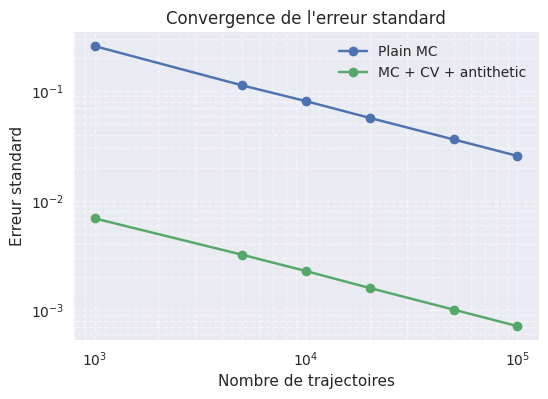

In [ ]:
n_paths_grid = [1_000, 5_000, 10_000, 20_000, 50_000, 100_000]
plain_errs = []
cv_errs = []

base_params = {
    "spot": 100.0,
    "strike": 100.0,
    "rate": 0.05,
    "sigma": 0.2,
    "maturity": 1.0,
    "n_obs": 50,
    "option_type": "call",
}

for n_paths in n_paths_grid:
    p_price, p_err = asian_mc_plain(n_paths=n_paths, seed=123, **base_params)
    cv_price, cv_err, _ = asian_mc_control_variate(n_paths=n_paths, antithetic=True, seed=123, **base_params)
    plain_errs.append(p_err)
    cv_errs.append(cv_err)



## 6. Heatmaps de prix en fonction de K et T

On fixe un spot `S0` et on regarde le prix d'un call et d'un put asiatiques arithmétiques en fonction du strike `K` et de la maturité `T`.

On utilise le Monte Carlo avec variates antithétiques + control variate pour obtenir deux surfaces relativement lisses.

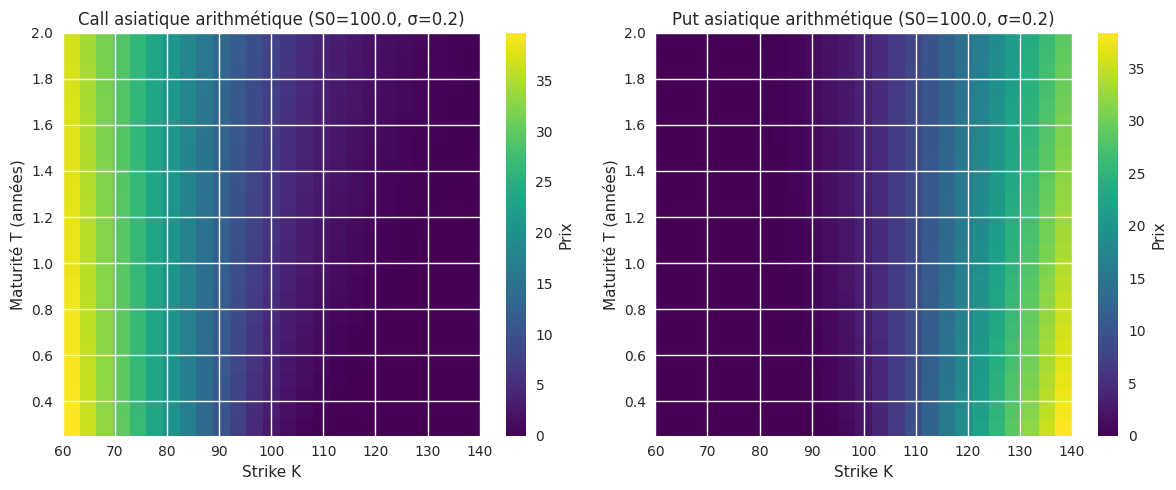

In [34]:
# Paramètres globaux pour les surfaces (call et put)
S0 = 100.0
r = 0.05
sigma = 0.2

K_min, K_max, n_K = 60.0, 140.0, 25
T_min, T_max, n_T = 0.25, 2.0, 25

K_values = np.linspace(K_min, K_max, n_K)
T_values = np.linspace(T_min, T_max, n_T)

n_paths_surface = 20_000

# Surfaces pour call et put
prices_call = np.zeros((n_T, n_K), dtype=float)
prices_put = np.zeros((n_T, n_K), dtype=float)

for i_T, T in enumerate(T_values):
    # On fait croître le nombre d'observations avec T
    n_obs = max(2, int(50 * T))
    for i_K, K in enumerate(K_values):
        # Call asiatique
        price_call, _, _ = asian_mc_control_variate(
            spot=S0,
            strike=K,
            rate=r,
            sigma=sigma,
            maturity=T,
            n_obs=n_obs,
            n_paths=n_paths_surface,
            option_type="call",
            antithetic=True,
            seed=None,
        )
        prices_call[i_T, i_K] = price_call

        # Put asiatique
        price_put, _, _ = asian_mc_control_variate(
            spot=S0,
            strike=K,
            rate=r,
            sigma=sigma,
            maturity=T,
            n_obs=n_obs,
            n_paths=n_paths_surface,
            option_type="put",
            antithetic=True,
            seed=None,
        )
        prices_put[i_T, i_K] = price_put

# Affichage des deux heatmaps côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(
    prices_call,
    origin="lower",
    extent=[K_min, K_max, T_min, T_max],
    aspect="auto",
    cmap="viridis",
)
axes[0].set_xlabel("Strike K")
axes[0].set_ylabel("Maturité T (années)")
axes[0].set_title(f"Call asiatique arithmétique (S0={S0}, σ={sigma})")
fig.colorbar(im0, ax=axes[0], label="Prix")

im1 = axes[1].imshow(
    prices_put,
    origin="lower",
    extent=[K_min, K_max, T_min, T_max],
    aspect="auto",
    cmap="viridis",
)
axes[1].set_xlabel("Strike K")
axes[1].set_ylabel("Maturité T (années)")
axes[1].set_title(f"Put asiatique arithmétique (S0={S0}, σ={sigma})")
fig.colorbar(im1, ax=axes[1], label="Prix")

plt.tight_layout()
plt.show()